In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

## Functions ##

In [6]:
def calculate_transport(basedir, dir1, section):
    filename = 'ariane_positions_quantitative.nc'
    with nc.Dataset(os.path.join('/data/sallen/results/Ariane',basedir, dir1, filename)) as dataset:
        final_section = dataset.variables['final_section'][:]
        final_transport = dataset.variables['final_transp'][:]
        vic_transport = np.sum(np.where(final_section == section, final_transport, 0))
    return (vic_transport/24.)

In [229]:
def get_data(start, endtime, basedir, section):
    transport = np.zeros(365*2+1)
    timerange = arrow.Arrow.range('day', start, endtime)
    time = []
    for i, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
        transport[i] = calculate_transport(basedir, dir1, section)
        time.append(r.datetime)
    return time, transport[:len(timerange)]  

## Get the Data ##

In [243]:
start = datetime.datetime(2015, 1, 1)
endtime = datetime.datetime(2015, 12, 26)
time, transport = get_data(start, endtime, 'FullSouth', 2)
fullsouth_transport = pd.DataFrame(data=transport, index=time, columns=['transport'])
time, transport = get_data(start, endtime, 'FullNorth', 2)
#fullnorth_transport = pd.DataFrame(data=transport, index=time, columns=['transport'])

In [248]:
start = datetime.datetime(2016, 7, 1)
endtime = datetime.datetime(2016, 7, 31)
#time, transport = get_data(start, endtime, 'FullSouth', 2)
#fullsouth_transport_16 = pd.DataFrame(data=transport, index=time, columns=['transport'])
time, transport = get_data(start, endtime, 'FullNorth', 2)
fullnorth_transport_16 = pd.DataFrame(data=transport, index=time, columns=['transport'])

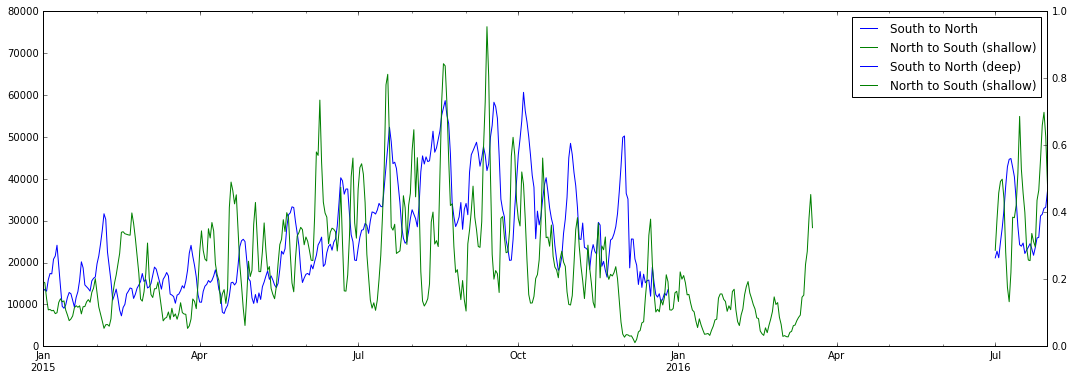

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax2 = ax.twinx()
fullsouth_transport.plot(ax=ax, y='transport', label="South to North", legend=False)
fullnorth_transport.plot(ax=ax, y='transport', label="North to South (shallow)", legend=False)
fullsouth_transport_16.plot(ax=ax, y='transport', label="South to North (deep)", legend=False, c='b')
fullnorth_transport_16.plot(ax=ax, y='transport', label="North to South (shallow)", legend=False, c='g')
#low_pass_tide.plot(ax=ax2, c='r')
ax.set_xlim(fullsouth_transport.index[0], time[-1])
ax.legend()

## Calculation of Tides moved to "Calculate Tides" ##
Here just read them

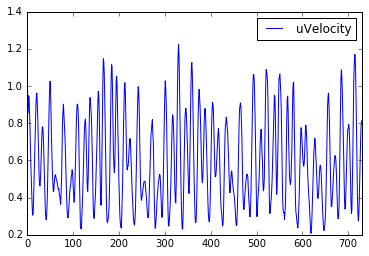

In [224]:
low_pass_tide = pd.read_csv('low_pass_tide.csv')
low_pass_tide.plot()

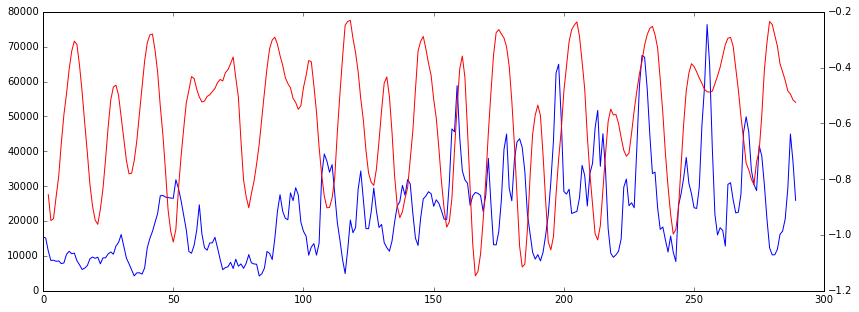

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = 0
ii, jj = 0-min(0,lag), 290-min(0,lag)
ax.plot(range(ii, jj), fullnorth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

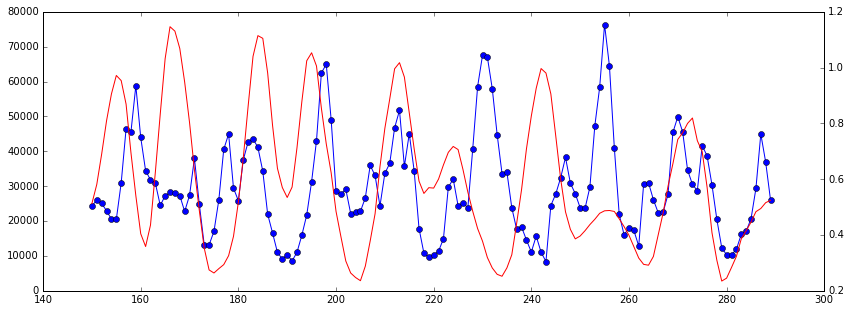

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = 0
ii, jj = 150-min(0,lag), 290-min(0,lag)
ax.plot(range(ii, jj), fullnorth_transport['transport'][ii+lag:jj+lag], 'o-')
ax2.plot(range(ii, jj), low_pass_tide['uVelocity'][ii:jj], 'r')

## Summer Deep Water Variability ##

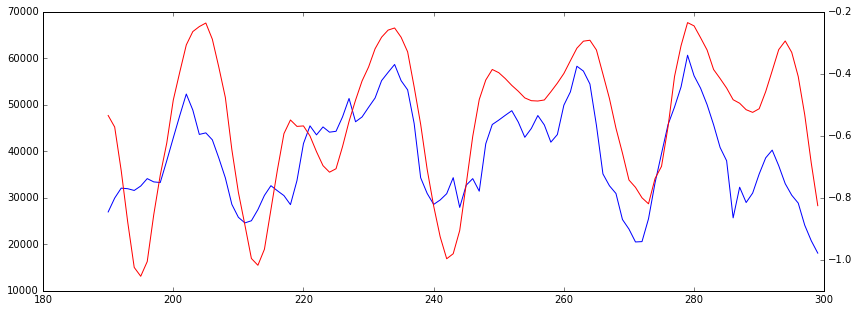

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Spring Deep Water Variability ##

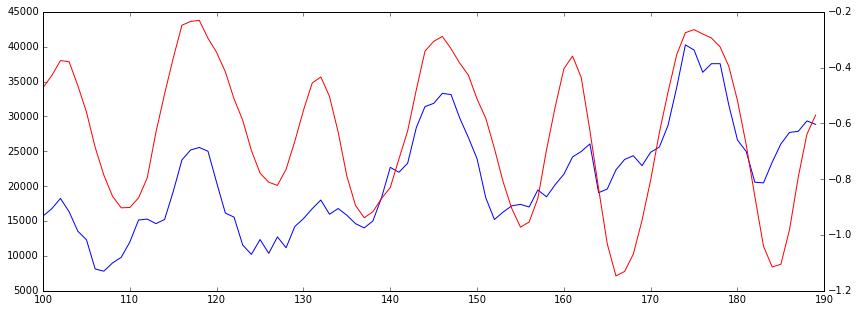

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

## Winter Deep Water Variability : note change in lag

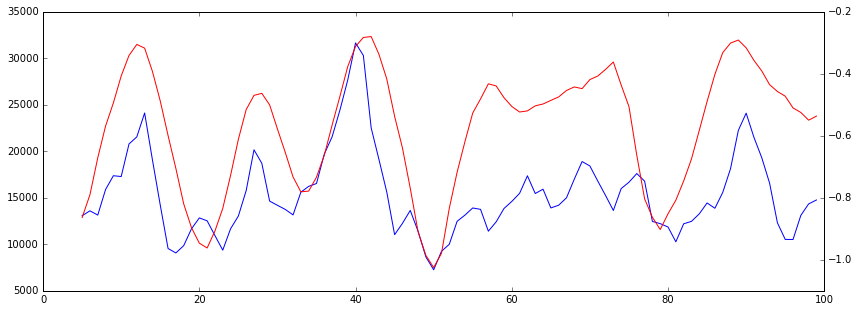

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -5
ii, jj = 0-lag, 100
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

In [192]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

In [212]:
tracers = nc.Dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')
iY = 258; iX = 178; iZ = 28
iY2 = 388; iX2 = 271
salinity = tracers.variables['salinity'][0:24*365:24, :iZ, iY, iX]
salinity2 = tracers.variables['salinity'][0:24*365:24, :iZ, iY2, iX2]

In [198]:
e3t = mesh.variables['e3t_0'][0, :iZ, iY, iX]

array([  1.00000115,   1.00000501,   1.00001253,   1.00002718,
         1.0000557 ,   1.00011125,   1.00021946,   1.0004302 ,
         1.00084067,   1.00164012,   1.0031971 ,   1.00622914,
         1.01213271,   1.02362358,   1.04597551,   1.08940061,
         1.17356428,   1.33592899,   1.64636781,   2.22990285,
         3.29248567,   5.11998508,   7.97451506,  11.8252972 ,
        16.10792044,  19.95870258,  22.81323256,   9.1497658 ])

In [213]:
saldiff = np.zeros(365)
for i in range(365):
    saldiff[i] = np.sum(salinity[i]*e3t) - np.sum(salinity2[i]*e3t)

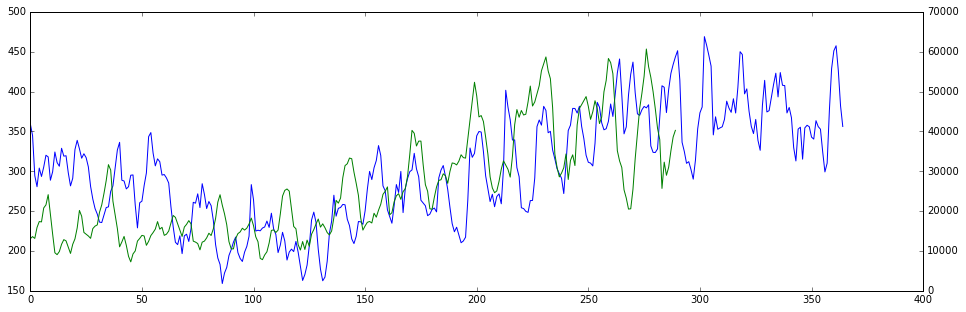

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax2 = ax.twinx()
ax.plot(saldiff)
ax2.plot(range(0, 290), fullsouth_transport['transport'][0:290], 'g')

In [11]:
fs = open('gulfisland_fullsouth_early2015', 'wb')
pickle.dump(gulfislands, fs)
fs.close()

In [16]:
fs = open('fullsouth_early2015', 'wb')
pickle.dump(fullsouth_transport, fs)
fs.close()

In [5]:
vic_transport_2015 = pickle.load('vic_transport_2015')
plt.plot(vic_transport_2015)

AttributeError: module 'pickle' has no attribute 'get'

In [59]:
fs = open('vic_transport_2015', 'wb')
pickle.dump(vic_transport, fs)

In [62]:
vsq = pd.read_csv('../day_avg_tide_pd.csv')

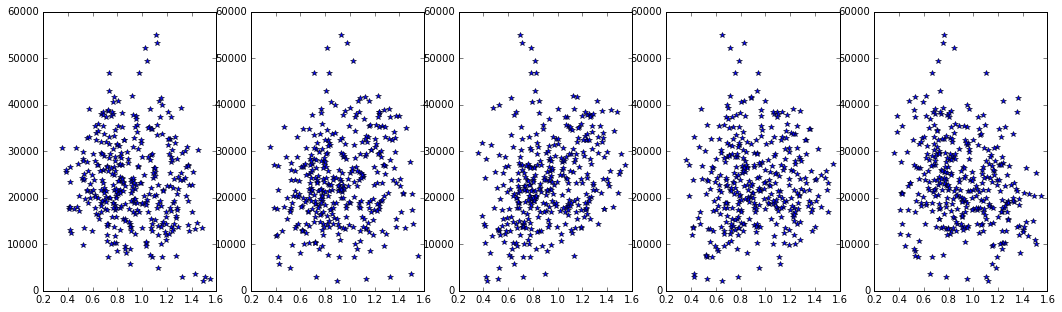

In [79]:
fig, ax = plt.subplots(1, 5, figsize=(18, 5))
for i, lag in enumerate(range(-7, 7, 3)):
    ax[i].plot(vsq[99+lag:99+365+lag].uVelocity, vic_transport, '*')
#    print (np.correlate(vsq[99+lag:99+365+lag], vic_transport[:]), lag, mode='valid')

In [18]:
print (final_section[:10])

[0 3 0 0 3 -- 0 0 0 3]


In [19]:
print (final_transport[:10])

[ 291.94831353  434.32313811  385.77470201  405.66511235  400.87030859
  296.97880037  291.83751423  434.02748407  378.15195964  396.87871675]
